Found 29 result files
Loaded 29 results
   model_size  noise_level  mutual_information     true/error
0         35M     0.000010            3.040060   99999.000000
1          8M     0.000010            3.038883   99999.000000
2        150M     0.000100            2.948196    9999.000000
3        150M     0.909091            0.029069       0.100000
4         35M     0.990099            0.033209       0.010000
5          8M     0.000001            3.076528  999999.000000
6         35M     0.000001            3.132483  999999.000000
7          8M     0.990099            0.008165       0.010000
8         35M     0.909091            0.057934       0.100000
9          8M     0.909091            0.087130       0.100000
10        35M     0.000100            2.998107    9999.000000
11         8M     0.000100            3.090084    9999.000000
12       150M     0.000001            2.916702  999999.000000
13       150M     0.990099            0.004421       0.010000
14       150M     0.000010    

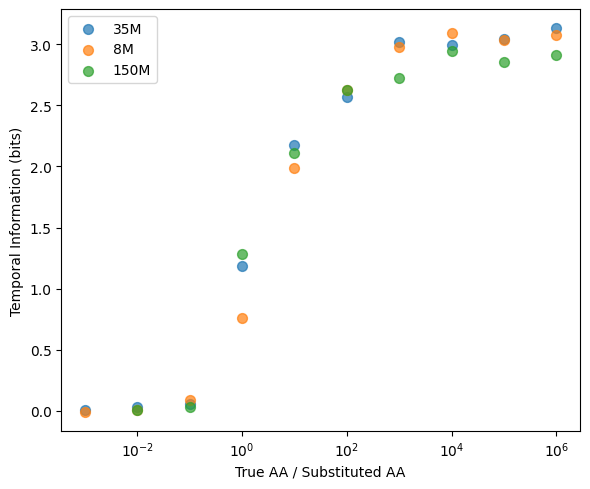

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lmfit import Model
import glob

# Collect all result files
result_files = glob.glob('seq/result_*.csv')
print(f"Found {len(result_files)} result files")

# Load and combine all results
results_list = []
for f in result_files:
    df = pd.read_csv(f)
    results_list.append(df)

res_df = pd.DataFrame(pd.concat(results_list, ignore_index=True))
res_df = res_df[res_df['noise_level'] <= 1]
res_df['true/error'] = (1 - res_df['noise_level']) / res_df['noise_level']

print(f"Loaded {len(res_df)} results")
print(res_df)

# Save combined results
res_df.to_csv('seq/multisize_gisaid_results.csv', index=False)
print("\nSaved to seq/multisize_gisaid_results.csv")

# Plot
palette = sns.color_palette("tab10", n_colors=10)
plt.figure(figsize=(6, 5))

for model_name in res_df['model_size'].unique():
    model_data = res_df[res_df['model_size'] == model_name]
    plt.scatter(model_data['true/error'], model_data['mutual_information'], 
                label=f'{model_name}', s=50, alpha=0.7)

plt.xscale('log')
plt.ylabel('Temporal Information (bits)')
plt.xlabel('True AA / Substituted AA')
plt.legend()
plt.tight_layout()
plt.show()


35M parameters:
  x_bar: 18.79
  I_max: 2.9850

8M parameters:
  x_bar: 36.76
  I_max: 3.0228

150M parameters:
  x_bar: 13.09
  I_max: 2.8273


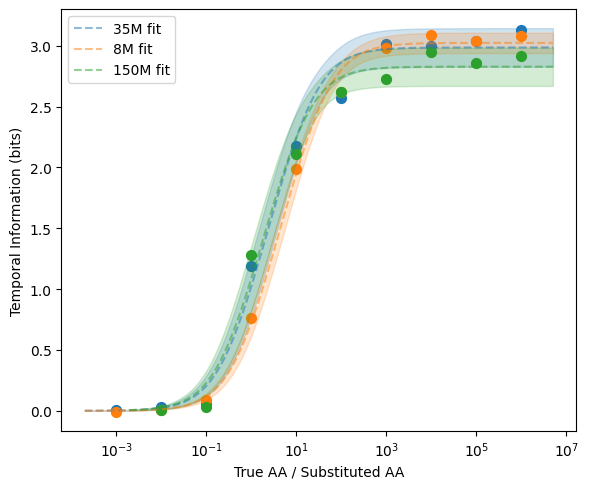

In [2]:
# Cell: Fit scaling law
def info_scaling(x, A, B):
    return 0.5 * np.log2((x*B + 1)/(1 + A*x))

res_df = pd.read_csv('seq/multisize_gisaid_results.csv')

palette = sns.color_palette("tab10", n_colors=10)

plt.figure(figsize=(6, 5))

for model_name in res_df['model_size'].unique():
    model_data = res_df[res_df['model_size'] == model_name]
    x_data = model_data['true/error']
    y_data = model_data['mutual_information']
    
    # Create model and fit
    model = Model(info_scaling)
    params = model.make_params(A=1e-2, B=1e-2)
    params['A'].min = 0
    params['B'].min = 0
    
    result = model.fit(y_data, params, x=x_data)
    
    # Generate fit line
    x_fit = np.logspace(np.log10(x_data.min()/5), np.log10(5*x_data.max()), 10**5)
    y_fit = model.eval(params=result.params, x=x_fit)
    
    # Calculate confidence bands
    y_upper = result.eval_uncertainty(params=result.params, x=x_fit, sigma=2)
    y_lower = -y_upper
    
    color = palette[list(res_df['model_size'].unique()).index(model_name)]
    
    # Plot
    plt.plot(x_fit, y_fit, linestyle='--', color=color, alpha=0.5, label=f'{model_name} fit')
    plt.fill_between(x_fit, y_fit + y_upper, y_fit + y_lower, color=color, alpha=0.2)
    plt.scatter(x_data, y_data, color=color, s=50)
    
    # Print parameters
    x_bar = 1/result.params['A'].value
    I_max = 0.5*np.log2(result.params['B'].value/result.params['A'].value)
    print(f"\n{model_name} parameters:")
    print(f"  x_bar: {x_bar:.2f}")
    print(f"  I_max: {I_max:.4f}")

plt.xscale('log')
plt.ylabel('Temporal Information (bits)')
plt.xlabel('True AA / Substituted AA')
plt.legend()
plt.tight_layout()
plt.show()